# 11 - Propensity Score

## The Psychology of Growth

The field of positive psychology studies what human behaviours lead to a great life. You can think of it as the intersection between self help books with the academic rigor of statistics. One of the famous findings of positive psychology is the **Growth Mindset**. The idea is that people can have a fixed or a growth mindset. If you have a fixed mindset, you believe that abilities are given at birth or in early childhood. As such, intelligence is fixed and can't change throughout life. If you don't have it by now, you can't acquire it. The corollary of this thought is that you should not waste time on areas where you don't excel, since you will never learn how to handle them. On the other hand, if you have a growth mindset, you believe that intelligence can be developed. The direct consequence of this is you see failure not as lack of tenacity, but as part of a learning process. 

I don't want to debate which of these mindsets is the correct one (although it's probably somewhere in the middle). For our purpose, it doesn't matter much. What does matter is that psychologists found out that people who have a growth mindset tend to do better in life. They are more likely to achieve what they've set out to do.

As versed as we are with causal inference, we've learned to see those statements with skepticism. Is it that a growth mindset causes people to achieve more? Or is simply the case that people who achieve more are prone to develop a growth mindset as a result of their success? Who came first, the egg or the chicken? In potential outcome notation, we have reasons to believe that there is bias in these statements. $Y_0|T=1$ is probably larger than $Y_0|T=0$, which means that those with a growth mindset would have achieved more even if they had a fixed mindset. 

To settle things, researchers designed the [The National Study of Learning Mindsets](https://mindsetscholarsnetwork.org/about-the-network/current-initatives/national-mindset-study/#). It is a randomised study conducted in U.S. public high schools which aims at finding the impact of a growth mindset. The way it works is that students receive from the school a seminar to instil in them a growth mindset. Then, they follow up the students in their college years to measure how well they've performed academically. This measurement was compiled into an achievement score and standardized. The real data on this study is not publicly available in order to preserve students' privacy. However, we have a simulated dataset with the same statistical properties provided by [Athey and Wager](https://arxiv.org/pdf/1902.07409.pdf), so we will use that instead. 

In [36]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from matplotlib import style
from matplotlib import pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
from causalinference import CausalModel

import graphviz as gr

%matplotlib inline

style.use("fivethirtyeight")
pd.set_option("display.max_columns", 6)

Besides the treated and outcome variables, the study also recorded some other features:

* schoolid: identifier of the student's school;
* success_expect:  self-reported expectations for success in the future, a proxy for prior achievement, measured prior to random assignment;
* ethnicity: categorical variable for student race/ethnicity;
* gender: categorical variable for student identified gender;
* frst_in_family: categorical variable for student first-generation status, i.e. first in family to go to college;
* school_urbanicity: school-level categorical variable for urbanicity of the school, i.e. rural, suburban, etc;
* school_mindset: school-level mean of students’ fixed mindsets, reported prior to random assignment, standardized;
* school_achievement: school achievement level, as measured by test scores and college preparation for the previous 4 cohorts of students, standardized; 
* school_ethnic_minority: school racial/ethnic minority composition, i.e., percentage of student body that is Black, Latino, or Native American, standardized;
* school_poverty: school poverty concentration, i.e., percentage of students who are from families whose incomes fall below the federal poverty line, standardized;
* school_size: total number of students in all four grade levels in the school, standardized.

In [37]:
data = pd.read_csv("./data/learning_mindset.csv")
data.sample(5, random_state=5)

,schoolid,intervention,achievement_score,...,school_ethnic_minority,school_poverty,school_size
259,73,1,1.480828,...,-0.515202,-0.169849,0.173954
3435,76,0,-0.987277,...,-1.310927,0.224077,-0.426757
9963,4,0,-0.152340,...,0.875012,-0.724801,0.761781
4488,67,0,0.358336,...,0.315755,0.054586,1.862187
2637,16,1,1.360920,...,-0.033161,-0.982274,1.591641


Although the study was `randomised`, it doesn't seem to be the case that this data is free from `confounding`. 
- If we look at the additional features, we will notice that they vary systematically between treatment and control. 
- One possible reason for this is that the treatment variable is measured by the __student's receipt of the seminar__. 
- So, although the opportunity to participate was random, __participation itself is not__. 
- We are dealing with a case of non-compliance here. 

One evidence of this is how the student's `success expectation` is correlated with the participation in the seminar. Students with higher self-reported success expectation are more likely to have joined the growth mindset seminar.

In [38]:
data.groupby("success_expect")["intervention"].mean()

success_expect
1    0.271739
2    0.265957
3    0.294118
4    0.271617
5    0.311070
6    0.354287
7    0.362319
Name: intervention, dtype: float64

Still, let's see what the difference in means $E[Y|T=1] - E[Y|T=0]$ looks like. This will be a useful baseline to compare against.

In [4]:
smf.ols("achievement_score ~ intervention", data=data).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-0.1538,0.012,-13.201,0.000,-0.177,-0.131
intervention,0.4723,0.020,23.133,0.000,0.432,0.512


Simply comparing those with and without the intervention, we can see that the treated have an achievement score that is, on average, 0.3185 (0.4723 - 0.1538) higher than the average score (which is zero, since the score is standardized). But is this big or small? I know that interpreting standardized outcomes can be challenging, but bear with me for a moment. I think it is worth going through this because it won't be the last time you will encounter standardized scores.
 
The outcome variable being standardized means that it is measured in standard deviations. So, the treated are 0.3185 deviations above the untreated. That is what this means. As for if this is small or big, let's remember some stuff about the normal distribution. We know that 95% of its mass is between 2 standard deviations, leaving 2.5% on one tail and 2.5% on another. This also means that if someone is 2 standard deviations above the mean, 97.5% (95% plus the left 2.5% tail) of all the individuals are below that person. By looking at the normal CDF, we also know that about 85% of its mass is below 1 standard deviation and that 70% of its mass is below 0.5 standard deviations. Since the treated group has an average standardized score of about 0.5, this means that they fall above 70% in terms of individual achievement. Or, in other words, they are in the top 30% who achieve more. Here is what this looks like in a picture.

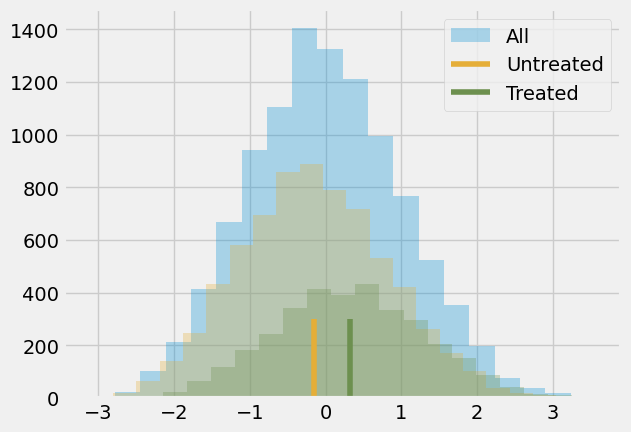

In [3]:
plt.hist(data["achievement_score"], bins=20, alpha=0.3, label="All")
plt.hist(data.query("intervention==0")["achievement_score"], bins=20, alpha=0.3, color="C2")
plt.hist(data.query("intervention==1")["achievement_score"], bins=20, alpha=0.3, color="C3")
plt.vlines(-0.1538, 0, 300, label="Untreated", color="C2")
plt.vlines(-0.1538+0.4723, 0, 300, label="Treated", color="C3")
plt.legend();

Of course, we still think this result is `biased`. 
- The difference between treated and untreated is probably smaller than this, because we think the bias is positive. 
- We've already seen that __more ambitious people are more willing to go to the seminar__, so they probably would have achieved more even if they had not attended it. 
- To control for this bias, we could use regression or matching, but it's time to learn about a new technique.

---

## Propensity Score

`Propensity score` comes from the realisation that you don't need to directly control for confounders X to achieve conditional independence $(Y_1, Y_0) \perp T | X$. 

Instead, it is sufficient to __control for a balancing score $E[T|X]$.__ 
- This balancing score is often the conditional probability of the treatment, $P(T|X)$, also called the propensity score $e(x)$. 
- The propensity score makes it so that you don't have to condition on the entirety of X to achieve independence of the potential outcomes on the treatment. 
- It is sufficient to condition on this single variable, which is the propensity score:

$
(Y_1, Y_0) \perp T | e(x)
$

There is a formal proof for why this is, but we can forget it for now and approach the matter in a more intuitive way. 

The propensity score is the __conditional probability of receiving the treatment__, right? So we can think of it as some sort of function that converts X into the treatment T. The propensity score makes this middle ground between the variable X and the treatment T. If we show this in a causal graph, this is what it would look like.

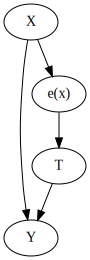

In [6]:
g = gr.Digraph()
g.edge("T", "Y")
g.edge("X", "Y")
g.edge("X", "e(x)")
g.edge("e(x)", "T")
g

__If I know what e(x) is, X alone tells me nothing more that can help me learn what T would be__. Which means that controlling for e(x) acts the same way as controlling for X directly.

Think of it in terms of our mindset program. Treated and non treated are initially not comparable because the more ambitious are both more likely to take the treatment and of achieving more in life. However, if I take 2 individuals, one from the treated and one from the control, but __with the same probability of receiving the treatment__, they are __comparable__. 

Think about it. If they have the exact same probability of receiving the treatment, the only reason one of them received it and the other did not is pure chance. 

Holding the propensity score constant acts in a way of making the data look as good as __random__. 

Now that we got the intuition, let's look at the mathematical proof. We want to show that $(Y_1, Y_0) \perp T | e(x)$ is equivalent to saying that 

$
E[T|e(x), X] = E[T|e(x)] 
$

This simply says that once I condition on $e(x)$, X can give me no extra information about $T$. The proof of this is quite weird. We will show that the equation above is true by converting it to a trivial statement. First take a look at the left hand side $E[T|e(x), X]$.

$
E[T|e(x), X] = E[T|X] = e(x)
$

We use the fact that $e(x)$ is just a function of X, so conditioning on it gives no further information after we've conditioned on X itself. Then, we use the definition of the propensity score $E[T|X]$. 

For the right hand side, we will use the law of iterated expectations $E[A] = E[E[A|B]]$. This law says that we can compute the expected value of A by looking at the value of A broken down by B and then averaging that. 

$
E[T|e(x)] = E[E[T|e(x),X]|e(x)] = E[e(x)|e(x)] = e(x)
$

The first equality comes from the law of iterated expectations. The second comes from what we've figured out when dealing with the left hand side. Since both the left and right hand side equals, $e(x)$, this equation is trivially true.

## Propensity Weighting

![img](./data/img/ps/balance.png)

OK, we got the propensity score. Now what? Like I've said, all we need to do is condition on it. 

For example, we could __run a linear regression that conditions only on the propensity score, instead of all the Xs__. 

For now, let's look at a technique that just uses the propensity score and nothing else. The idea is to write the conditional difference in means with the propensity score

$
E[Y|X,T=1]-E[Y|X,T=0] = E\bigg[\dfrac{Y}{e(x)}|X,T=1\bigg]P(T) - E\bigg[\dfrac{Y}{(1-e(x))}|X,T=0\bigg](1-P(T))
$

We can simplify this further, but let's take a look at it like this because it gives us some nice intuition of what the propensity score is doing. 
- The first term is estimating $Y_1$. It is taking all those that are treated and scaling them by the __inverse probability__ of treatment. __What this does is it makes those with very low probability of treatment have a high weight__. 
   - This makes sense, right? If someone has a low probability of treatment, that individual looks like the untreated. 
   - However, that same individual was treated. This must be interesting. 
   - We have a treated that looks like the untreated, so we will give that entity a __high weight__. 
   - This creates a population with the same size as the original, but where everyone is treated. 
- By the same reasoning, the other term looks at the untreated and gives a high weight to those that look like the treated. 
- This estimator is called the __Inverse Probability of Treatment Weighting (IPTW)__, since it scales each unit by the inverse probability of the treatment it received.

In a picture, here is what this weighting does.

![img](./data/img/ps/iptw.png)

The upper left plot shows the original data. The blue dots are the untreated and the red dots are the treated. The bottom plot shows the propensity score $e(x)$. Notice how it is between 0 and 1 and it grows as X increases. Finally, the upper right plot is the data after weighting. Notice how the red (treated) that are more to the left (lower propensity score) have a higher weight. Similarly, the blue plots that are to the right have also a higher weight. 

Now that we got the intuition, we can simplify the terms above to

$$
\begin{align}
E[Y|X,T=1]-E[Y|X,T=0] &= E\bigg[\dfrac{Y}{e(x)}|X,T=1\bigg]P(T) - E\bigg[\dfrac{Y}{(1-e(x))}|X,T=0\bigg](1-P(T)) \\
&=E\bigg[\dfrac{YT}{e(x)}\bigg|X\bigg] - E\bigg[\dfrac{Y(1-T)}{(1-e(x))}\bigg|X\bigg] \\
&=E\bigg[\dfrac{YT}{e(x)} - \dfrac{Y(1-T)}{(1-e(x))}\bigg|X\bigg] \\
&=E\bigg[Y\dfrac{T(1-e(x)) - e(x)(1-T)}{e(x)(1-e(x))}\bigg|X\bigg] \\
&=E\bigg[Y \dfrac{T-e(x)}{e(x)(1-e(x))}\bigg|X\bigg]
\end{align}
$$

which if we integrate over X becomes our __`propensity score weighting estimator`__.

$
E\bigg[Y \dfrac{T-e(x)}{e(x)(1-e(x))}\bigg]
$

Notice that this estimator requires that $e(x)$ and $1-e(x)$ are larger than zero. 
- In words, this means that everyone needs to have at least some chance of receiving the treatment and of not receiving it. 
- Another way of stating this is that the treated and untreated distributions need to overlap. 
- This is the **positivity assumption** of causal inference. It also makes intuitive sense. 
- If treated and untreated don't overlap, it means they are very different and I won't be able to extrapolate the effect of one group to the other. 
- This extrapolation is not impossible (regression does it), but it is very dangerous. It is like testing a new drug in an experiment where only men receive the treatment and then assume women will respond to it equally well.


## Propensity Score Estimation

In an ideal world, we would have the true propensity score $e(x)$. However, in practice, the mechanism that assigns the treatment is unknown and we need to __replace the true propensity score by an estimation of it $\hat{e}(x)$.__ One common way of doing so is using __`Logistic Regression`__, but other machine learning methods, like gradient boosting, can be used as well (although it requires some additional steps to avoid overfitting). 

Here, I'll stick to logistic regression. This means that I'll have to convert the categorical features in the dataset to dummies. 

In [39]:
categ = ["ethnicity", "gender", "school_urbanicity"]
cont = ["school_mindset", "school_achievement", "school_ethnic_minority", "school_poverty", "school_size"]

data_with_categ = pd.concat([
    data.drop(columns=categ), # dataset without the categorical features
    pd.get_dummies(data[categ], columns=categ, drop_first=False)# categorical features converted to dummies
], axis=1)

print(data_with_categ.shape)

(10391, 32)


In [40]:
data_with_categ.head()

,schoolid,intervention,achievement_score,...,school_urbanicity_2,school_urbanicity_3,school_urbanicity_4
0,76,1,0.277359,...,0,0,1
1,76,1,-0.449646,...,0,0,1
2,76,1,0.769703,...,0,0,1
3,76,1,-0.121763,...,0,0,1
4,76,1,1.526147,...,0,0,1


Now, let's estimate the propensity score using logistic regression.

In [41]:
from sklearn.linear_model import LogisticRegression

T = 'intervention'
Y = 'achievement_score'
X = data_with_categ.columns.drop(['schoolid', T, Y])

ps_model = LogisticRegression(C=1e6).fit(data_with_categ[X], data_with_categ[T])

data_ps = data.assign(propensity_score=ps_model.predict_proba(data_with_categ[X])[:, 1])

In [42]:
data_ps[data_ps['intervention'] == 1][["intervention", "achievement_score", "propensity_score"]].head(10)

,intervention,achievement_score,propensity_score
0,1,0.277359,0.315489
1,1,-0.449646,0.263798
2,1,0.769703,0.344024
3,1,-0.121763,0.344024
4,1,1.526147,0.367789
5,1,0.009607,0.344024
6,1,1.743033,0.367789
7,1,0.953294,0.367789
8,1,2.367780,0.338334
9,1,1.264409,0.338300


In [43]:
data_ps[data_ps['intervention'] == 0][["intervention", "achievement_score", "propensity_score"]].head(10)

,intervention,achievement_score,propensity_score
3384,0,-2.081077,0.294055
3385,0,1.704537,0.326938
3386,0,0.457979,0.321562
3387,0,0.058448,0.359757
3388,0,0.085929,0.344024
3389,0,0.866304,0.344024
3390,0,-0.924880,0.294055
3391,0,1.475563,0.367789
3392,0,0.041954,0.310997
3393,0,1.569696,0.344024


In [45]:
print(min(data_ps['propensity_score']), max(data_ps['propensity_score']))

0.1323886827724041 0.5332191617163784


In [48]:
data_ps[data_ps["success_expect"] == 7].groupby("intervention")['propensity_score'].mean()

intervention
0    0.370139
1    0.376346
Name: propensity_score, dtype: float64

In [50]:
data_ps[data_ps["success_expect"] == 1].groupby("intervention")['propensity_score'].mean()

intervention
0    0.230680
1    0.233145
Name: propensity_score, dtype: float64

First, we can make sure that the propensity score weight indeed reconstructs a population where everyone is treated. 
- By producing weights $1/e(x)$, it creates the population where everyone is treated
- By providing the weights $1/(1-e(x))$ it creates the population where everyone is untreated.

In [56]:
data_ps.groupby('intervention').size()

intervention
0    7007
1    3384
dtype: int64

In [10]:
weight_t = 1/data_ps.query("intervention==1")["propensity_score"]
weight_nt = 1/(1-data_ps.query("intervention==0")["propensity_score"])
print("Original Sample Size", data.shape[0])
print("Treated Population Sample Size", sum(weight_t))
print("Untreated Population Sample Size", sum(weight_nt))

Original Sample Size 10391
Treated Population Sample Size 10388.575092093015
Untreated Population Sample Size 10391.438139669131


__We can also use the propensity score to find evidence of confounding__. 
- If a segmentation of the population has a higher propensity score than another, it means that something which is not random is causing the treatment. 
- If that same thing is also causing the outcome, we have confounding. 
- In our case, we can see that students that reported to be more ambitious also have a higher probability of attending the growth mindset seminar.

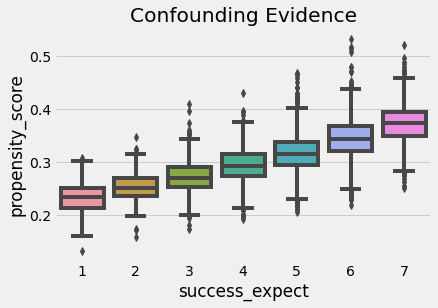

In [10]:
sns.boxplot(x="success_expect", y="propensity_score", data=data_ps)
plt.title("Confounding Evidence");

We also have to check that there is overlap between the treated and untreated population. 
- To do so, we can see the `empirical distribution` of the propensity score on the untreated and on the treated. 
- Looking at the image below, we can see that no one has a propensity score of zero and that even in lower regions of the propensity score we can find both treated and untreated individuals. 
- This is what we call a nicely balanced treated and untreated population. 

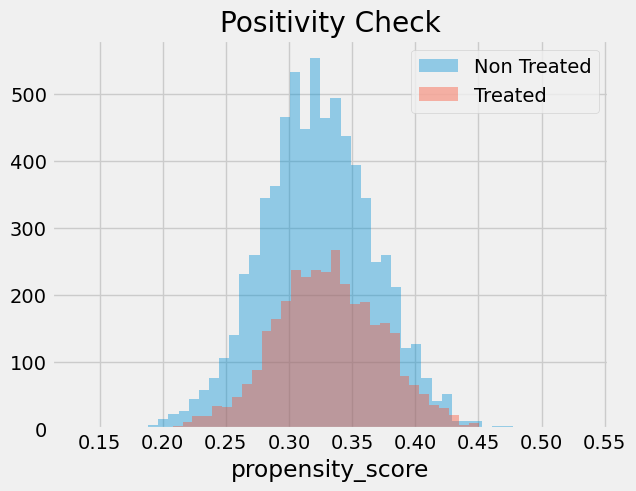

In [12]:
sns.distplot(data_ps.query("intervention==0")["propensity_score"], kde=False, label="Non Treated")
sns.distplot(data_ps.query("intervention==1")["propensity_score"], kde=False, label="Treated")
plt.title("Positivity Check")
plt.legend();

Finally, we can use our propensity score weighting estimator to __estimate the average treatment effect__. 

In [12]:
weight = ((data_ps["intervention"]-data_ps["propensity_score"]) /
          (data_ps["propensity_score"]*(1-data_ps["propensity_score"])))

y1 = sum(data_ps.query("intervention==1")["achievement_score"]*weight_t) / len(data)
y0 = sum(data_ps.query("intervention==0")["achievement_score"]*weight_nt) / len(data)

ate = np.mean(weight * data_ps["achievement_score"])

print("Y1:", y1)
print("Y0:", y0)
print("ATE", ate)

Y1: 0.2595823130696891
Y0: -0.1289241686986528
ATE 0.38850648176834174


Propensity score weighting is saying that we should expect treated individuals to be __0.38__ standard deviations above their untreated fellows, in terms of achievements. We can also see that if no one got the treatment, we should expect the general level of achievements to be 0.12 standard deviation lower than what it is now. By the same reasoning, we should expect the general level of achievement to be 0.25 standards deviation higher if we've given everyone the seminar. 

Contrast this to the __0.47 ATE__ estimate we've got by simply comparing treated and untreated. This is evidence that the __bias we have is indeed positive__ and that controlling for X gives us a more modest estimate of the impact of the growth mindset.

---

## Standard Error

![img](./data/img/ps/bootstrap.png)

To compute the standard error for the IPTW estimator, we can use the formula of the variance of a weighted average.

$
\sigma^2_w = \dfrac{\sum_{i=1}^{n}w_i(y_i-\hat{\mu})^2}{\sum_{i=1}^{n}w_i}
$

However, we can only use this if we have the true propensity score. If we are using the estimated version of it, $\hat{P}(x)$, we need to account for the __errors__ in this estimation process. 

The easiest way of doing this is by __bootstrapping__ the whole procedure. This is achieved by __sampling with replacement__ from the original data and computing the ATE like we did above. We then repeat this many times to get the __distribution of the ATE estimate__.

In [13]:
from joblib import Parallel, delayed # for parallel processing

# define function that computes the IPTW estimator
def run_ps(df, X, T, y):
    # estimate the propensity score
    ps = LogisticRegression(C=1e6, max_iter=1000).fit(df[X], df[T]).predict_proba(df[X])[:, 1]
    
    weight = (df[T]-ps) / (ps*(1-ps)) # define the weights
    return np.mean(weight * df[y]) # compute the ATE

np.random.seed(88)
# run 1000 bootstrap samples
bootstrap_sample = 1000
ates = Parallel(n_jobs=4)(delayed(run_ps)(data_with_categ.sample(frac=1, replace=True), X, T, Y)
                          for _ in range(bootstrap_sample))
ates = np.array(ates)

The ATE is then the mean of the bootstrap samples. To get confidence intervals, we can inspect the quantiles of the bootstrap distribution. For the 95% C.I., we use the 2.5 and 97.5 percentiles.

In [14]:
print(f"ATE: {ates.mean()}")
print(f"95% C.I.: {(np.percentile(ates, 2.5), np.percentile(ates, 97.5))}")

ATE: 0.3877462160640629
95% C.I.: (0.3544632385789277, 0.41992558677601066)


We can also have a visual on what the bootstrap samples look like, along with the confidence intervals.

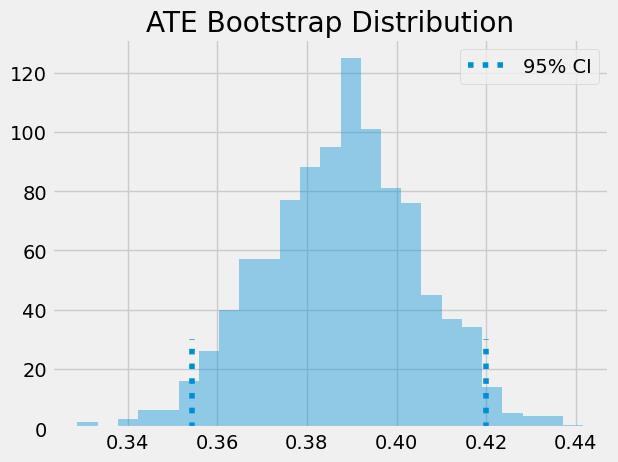

In [15]:
sns.distplot(ates, kde=False)
plt.vlines(np.percentile(ates, 2.5), 0, 30, linestyles="dotted")
plt.vlines(np.percentile(ates, 97.5), 0, 30, linestyles="dotted", label="95% CI")
plt.title("ATE Bootstrap Distribution")
plt.legend();

## Common Issues with Propensity Score

As a data scientist, I know it can be tempting to use all the power of the machine learning toolkit to make propensity score estimation as precise as possible. You can quickly get taken away by the all AUC optimisation, cross validation and bayesian hyper-parameter tuning. Now, I'm not saying you shouldn't do that. In fact, all of the theory about propensity score and machine learning is very recent, so there are lots we don't know yet. But it pays to understand something first. 

The first thing is that the __predictive quality of the propensity score does not translate into its balancing properties__. 
- Coming from the field of machine learning, one of the most challenging aspects of getting acquainted with causal inference is letting go of treating everything as a prediction problem. 
- In fact, maximising the prediction power of the propensity score can even hurt the causal inference goal. 
- **Propensity score doesn't need to predict the treatment very well. It just needs to include all the confounding variables**. 
- If we include variables that are very good in predicting the treatment but have no bearing on the outcome this will actually increase the variance of the propensity score estimator. This is similar to the problem linear regression faces when we include variables correlated with the treatment but not with the outcome. 

![img](./data/img/ps/ml-trap.png)

To see this, consider the following example (adapted from Hernán's Book). You have 2 schools, one of them apply the growth mindset seminar to 99% of its students and the other to 1%. Suppose that the schools have no impact on the treatment effect (except through the treatment), so it's not necessary to control for it. 

If you add the school variable to the propensity score model, it's going to have a very high predictive power. However, by chance, __we could end up with a sample where everyone in school A got the treatment__, leading to a propensity score of 1 for that school, which would lead to an infinite variance. This is an extreme example, but let's see how it would work with simulated data.

In [26]:
np.random.seed(42)
school_a = pd.DataFrame(dict(T=np.random.binomial(1, .99, 400), school=0, intercept=1))
school_b = pd.DataFrame(dict(T=np.random.binomial(1, .01, 400), school=1, intercept=1))
print (school_a.head(10))
print (school_a['T'].mean())
print (school_b.head(10))
print (school_b['T'].mean())

   T  school  intercept
0  1       0          1
1  1       0          1
2  1       0          1
3  1       0          1
4  1       0          1
5  1       0          1
6  1       0          1
7  1       0          1
8  1       0          1
9  1       0          1
0.995
   T  school  intercept
0  0       1          1
1  0       1          1
2  0       1          1
3  0       1          1
4  0       1          1
5  0       1          1
6  0       1          1
7  0       1          1
8  0       1          1
9  0       1          1
0.0075


In [27]:
ex_data = pd.concat([school_a, school_b]).assign(y = lambda d: np.random.normal(1 + 0.1 * d["T"]))
ex_data.head()

,T,school,intercept,y
0,1,0,1,0.309526
1,1,0,1,1.571468
2,1,0,1,2.982024
3,1,0,1,2.445420
4,1,0,1,2.693187


In [31]:
ex_data[ex_data['T'] == 1]['y'].mean()

1.1661922402007852

In [30]:
ex_data[ex_data['T'] == 0]['y'].mean()

1.0778841435196347

Having simulated this data, we run bootstrap with the Propensity Score algorithm twice. The first including school as a feature to the propensity score model. The second time, we don't include school in the model.

In [32]:
ate_w_f = np.array([run_ps(ex_data.sample(frac=1, replace=True), ["school"], "T", "y") for _ in range(500)])
ate_wo_f = np.array([run_ps(ex_data.sample(frac=1, replace=True), ["intercept"], "T", "y") for _ in range(500)])

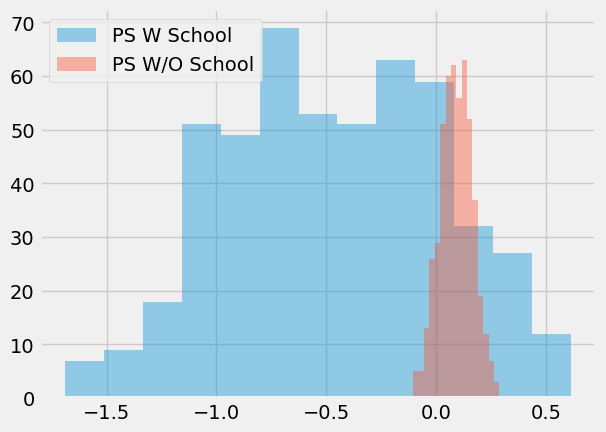

In [33]:
sns.distplot(ate_w_f, kde=False, label="PS W School")
sns.distplot(ate_wo_f, kde=False, label="PS W/O School")
plt.legend();

As you can see, the propensity score estimator that adds the feature school has a humongous variance, while the one without it is much more well behaved. 

Also, since school is not a confounder, the model without it is also not biased. As I've said, __simply predicting the treatment is not what this is about__. We actually need to construct the prediction in a way that controls for confounding, not in a way to predict the treatment. 

This leads to another problem often encountered in propensity score methods. In our mindset case, the data turned out to be very balanced. But this is not always the case. In some situations, the treated have a much higher probability of treatment than the untreated and the propensity score distribution doesn't overlap much.

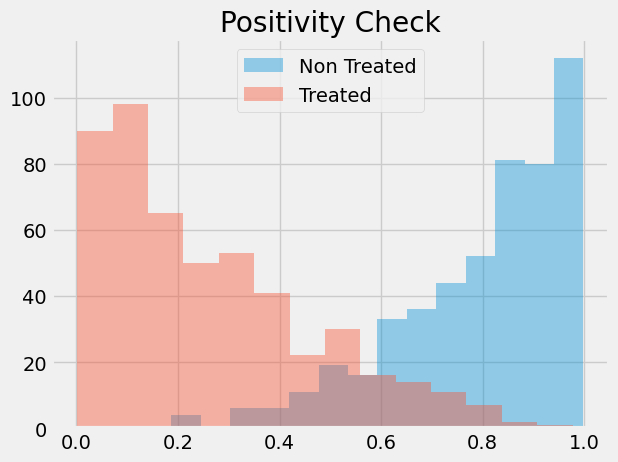

In [34]:
sns.distplot(np.random.beta(4,1,500), kde=False, label="Non Treated")
sns.distplot(np.random.beta(1,3,500), kde=False, label="Treated")
plt.title("Positivity Check")
plt.legend();

If this happens, it means that positivity is not very strong. If a treated has a propensity score of, say, 0.9 and the maximum propensity score of the untreated is 0.7, __we won't have any untreated to compare to the individual with the 0.9 propensity score__. This lack of balancing can generate some bias, because we will have to extrapolate the treatment effect to unknown regions. Not only that, entities with very high or very low propensity scores have a very high weight, which increases variance. As a general rule of thumb, you are in trouble if any weight is higher than 20 (which happens with an untreated with propensity score of 0.95 or a treated with a propensity score of 0.05). 

An alternative is clipping the weight to be at a maximum size of 20. This will decrease the variance, but it will actually generate more bias. To be honest, although this is a common practice to reduce variance, I don't really like it. You will never know if the bias you are inducing with clipping is too much. Also, if the distributions don't overlap, your data is probably not enough to make a causal conclusion anyway. To gain some further intuition about this, we can look at a technique that combines propensity score and matching

## Propensity Score Matching

As I've said before, you don't need to control for X when you have the propensity score. It suffices to control for it. 

As such, you can think of the propensity score as performing a kind of __dimensionality reduction on the feature space__. It condenses all the features in X into a single treatment assignment dimension. For this reason, we can treat the propensity score as an input feature for other models. 

Take a regression model for instance.

In [20]:
smf.ols("achievement_score ~ intervention + propensity_score", data=data_ps).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-3.0770,0.065,-47.061,0.000,-3.205,-2.949
intervention,0.3930,0.019,20.974,0.000,0.356,0.430
propensity_score,9.0554,0.200,45.314,0.000,8.664,9.447


If we control for the propensity score, we now estimate a ATE of 0.39, which is lower than the 0.47 we got previously with a regression model without controlling for the propensity score. 

We can also use __`matching`__ on the propensity score. This time, instead of trying to find matches that are similar in all the X features, we can find matches that just have the same propensity score.

This is a huge improvement on top of the matching estimator, since it deals with the curse of dimensionality. Also, if a feature is unimportant for the treatment assignment, the propensity score model will learn that and give low importance to it when fitting the treatment mechanism. Matching on the features, on the other hand, would still try to find matches where individuals are similar on this unimportant feature.

In [35]:
cm = CausalModel(
    Y=data_ps["achievement_score"].values, 
    D=data_ps["intervention"].values, 
    X=data_ps[["propensity_score"]].values
)

cm.est_via_matching(matches=1, bias_adj=True)

print(cm.estimates)


Treatment Effect Estimates: Matching

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE      0.396      0.025     15.838      0.000      0.347      0.445
           ATC      0.386      0.027     14.098      0.000      0.332      0.440
           ATT      0.415      0.027     15.545      0.000      0.363      0.468



As we can see, we also get an ATE of 0.38, which is more in line with what we've seen before with propensity score weighting. 

Matching on the propensity score also gives us some intuition about why __it is dangerous to have a small overlap in the propensity score between treated and untreated__. If this happens, the matching on the propensity score discrepancy will be large, which will lead to bias, as we've seen on the matching chapter. 

One final word of caution here is that the above standard errors are wrong, as they don't account for the uncertainty in the estimation of the propensity score. Unfortunately, [bootstrap doesn't work with matching](https://economics.mit.edu/sites/default/files/publications/ON%20THE%20FAILURE%20OF%20THE%20BOOTSTRAP%20FOR.pdf). Also, the theory above is so recent that there are no Python implementations of propensity score methods with the correct standard errors. For this reason, we don't see a lot of propensity score matching in Python. 

## Key Ideas

Here, we've learned that the probability of getting the treatment is called the propensity score and that we can use this as a balancing score. What this means is that, if we have the propensity score, we don't need to control for the confounders directly. It is sufficient to control for the propensity score in order to identify the causal effect. We saw how the propensity scores acts as a dimensionality reduction on the confounder space.

These properties allowed us to derive a weighting estimator for causal inference. Not only that, we saw how the propensity score can be used along other methods to control for confounding bias. 

Then, we looked at some common issues that can arise with propensity score and with causal inference in general. The first one is when we  get carried away by the task of fitting the treatment mechanism. We saw that, in a very counterintuitive (and hence easy to get it wrong) way, increasing the predictive performance of the treatment does **not** translate into a better causal estimate, as it can increase variance.

Finally, we looked at some extrapolation problems that we might run into if we are unable to have a good overlap between the treated and untreated propensity score distribution. 


## References

I like to think of this entire book as a tribute to Joshua Angrist, Alberto Abadie and Christopher Walters for their amazing Econometrics class. Most of the ideas here are taken from their classes at the American Economic Association. Watching them is what is keeping me sane during this tough year of 2020.
* [Cross-Section Econometrics](https://www.aeaweb.org/conference/cont-ed/2017-webcasts)
* [Mastering Mostly Harmless Econometrics](https://www.aeaweb.org/conference/cont-ed/2020-webcasts)

I'll also like to reference the amazing books from Angrist. They have shown me that Econometrics, or 'Metrics as they call it, is not only extremely useful but also profoundly fun.

* [Mostly Harmless Econometrics](https://www.mostlyharmlesseconometrics.com/)
* [Mastering 'Metrics](https://www.masteringmetrics.com/)

My final reference is Miguel Hernan and Jamie Robins' book. It has been my trustworthy companion in the most thorny causal questions I had to answer.

* [Causal Inference Book](https://www.hsph.harvard.edu/miguel-hernan/causal-inference-book/)

The data that we used was taken from the article [Estimating Treatment Effects with Causal Forests: An Application](https://arxiv.org/pdf/1902.07409.pdf), by Susan Athey and Stefan Wager. 

![img](./data/img/poetry.png)

## Contribute

Causal Inference for the Brave and True is an open-source material on causal inference, the statistics of science. It uses only free software, based in Python. Its goal is to be accessible monetarily and intellectually.
If you found this book valuable and you want to support it, please go to [Patreon](https://www.patreon.com/causal_inference_for_the_brave_and_true). If you are not ready to contribute financially, you can also help by fixing typos, suggesting edits or giving feedback on passages you didn't understand. Just go to the book's repository and [open an issue](https://github.com/matheusfacure/python-causality-handbook/issues). Finally, if you liked this content, please share it with others who might find it useful and give it a [star on GitHub](https://github.com/matheusfacure/python-causality-handbook/stargazers).